# Jo Wilder Session Data Exploration

This template is designed to help you explore per-session data from the Jo Wilder game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

# Environment Setup and Import

In [65]:
import os
print(os.getcwd())
!pip install --quiet -r ../../requirements.txt

d:\Luke Swanson\D_Documents\_work\FieldDay\OpenGameData\opengamedata-samples\WAVES\explore


In [66]:
# Standard Libraries
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [67]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Retrieve Data Files

#### Please change `OGD_SERVER` and `zip_name` if you want to get a file from a different location.
#### The cells below will error if `OGD_SERVER` and `zip_name` are invalid.

In [68]:
# Configure Server Info

OGD_SERVER = 'http://opengamedata.fielddaylab.wisc.edu/'
SERVER_DATA_PATH = 'data/WAVES/'

In [69]:
# Get the zip file.

dataset_name = "WAVES_20230201_to_20230228"
zip_name = f"{dataset_name}_5de1a1f_session-features.zip"

# download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {OGD_SERVER}...")
    file_url = f"{OGD_SERVER}{SERVER_DATA_PATH}{zip_name}"
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")
zip_file = ZipFile(Path(f'./{zip_name}'))

### Import Data Files to Jupyter

In [70]:
# Open TSV from the zip file.

tsv_name = f"{dataset_name}_5de1a1f_session-features.tsv"
raw_data = pd.read_csv(zip_file.open(f"{dataset_name}/{tsv_name}"), sep='\t')

# Data Overview

In [71]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12127 entries, 0 to 12126
Columns: 861 entries, PlayerID to lvl34_WavelengthGoodMoveCount
dtypes: bool(35), float64(330), int64(422), object(74)
memory usage: 76.8+ MB


In [72]:
print(f"This dataset has {raw_data.shape[0]} Rows, {raw_data.shape[1]} Columns")

This dataset has 12127 Rows, 861 Columns


### Column Names

Each Waves feature data file contains a large number of columns, each representing a single feature of gameplay.
Some features have one column per level, or one column per quiz question.
We call these **per-count** features.
Each **per-count** feature has a prefix indicating whether it was a *per-level* (prefix: `lvl`) or *per-quiz-question* (prefix: `QA`).  
Other features have only one column, based on play across all levels.
We call these **aggregate** or **session** features.

Below, the base feature names are listed.
**Per-count** features have the prefix shown in parentheses, and the number of columns with that base feature name shown to the right.
Note that **aggregate** features each have a "1" on the right, since each has just one column.

In [73]:
percount_prefixes = ['lvl', 'QA']
column_groups = {
  pre : []
  for pre in percount_prefixes + ['Aggregate']
}

for col in raw_data.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  found = False
  for pc_pre in percount_prefixes:
    if prefix.startswith(pc_pre):
      column_groups[pc_pre].append(f"({pc_pre}) {pieces[1]}")
      found = True
  if not found:
    column_groups['Aggregate'].append(col)
col_set = Counter(sum(column_groups.values(), []))
print(f"There are {len(raw_data.columns)} columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

There are 861 columns in 39 groups:
Counter({'(lvl) AmplitudeGoodMoveCount': 35,
         '(lvl) BeginCount': 35,
         '(lvl) Completed': 35,
         '(lvl) Completed-Count': 35,
         '(lvl) FirstMoveType': 35,
         '(lvl) OffsetGoodMoveCount': 35,
         '(lvl) PercentAmplitudeGoodMoves': 35,
         '(lvl) PercentAmplitudeMoves': 35,
         '(lvl) PercentOffsetGoodMoves': 35,
         '(lvl) PercentOffsetMoves': 35,
         '(lvl) PercentWavelengthGoodMoves': 35,
         '(lvl) PercentWavelengthMoves': 35,
         '(lvl) SequenceLevel': 35,
         '(lvl) SliderAverageRange': 35,
         '(lvl) SliderAverageStandardDeviations': 35,
         '(lvl) SucceedCount': 35,
         '(lvl) TotalArrowMoves': 35,
         '(lvl) TotalFails': 35,
         '(lvl) TotalLevelTime': 35,
         '(lvl) TotalMoveTypeChanges': 35,
         '(lvl) TotalResets': 35,
         '(lvl) TotalSkips': 35,
         '(lvl) TotalSliderMoves': 35,
         '(lvl) WavelengthGoodMoveCount': 3

### Feature Summaries

This section shows some basic statistical summaries of the feature columns listed above.
These summaries are across all sessions in the data file.

#### Summary of Aggregate (whole-session) features

In [74]:
raw_data[column_groups['Aggregate']].describe(include = 'all')

,PlayerID,SessionID,AverageFails,AverageLevelTime,AverageMoveTypeChanges,AverageSliderMoves,OverallPercentAmplitudeMoves,OverallPercentOffsetMoves,OverallPercentWavelengthMoves,OverallSliderAverageRange,OverallSliderAverageStandardDeviations,PersistentSessionID,SessionID.1
count,0.0,1.212700e+04,10214.000000,12099.000000,11512.000000,11472.000000,11512.000000,11512.000000,11512.000000,1.147200e+04,1.147200e+04,1.209900e+04,1.212700e+04
mean,NaN,2.301031e+16,4.395034,105.725985,1.600563,9.062432,25.544463,36.852451,37.603087,2.896399e+01,9.265761e+00,2.300597e+16,2.301031e+16
std,NaN,2.099137e+11,5.955671,794.665767,1.339763,6.668649,11.765121,14.642136,12.960949,1.232078e+01,4.566817e+00,6.191243e+13,2.099137e+11
min,NaN,2.300021e+16,1.000000,-66.135500,1.000000,1.000000,0.000000,0.000000,0.000000,1.421085e-14,7.105427e-15,2.210002e+16,2.300021e+16
25%,NaN,2.301021e+16,2.125000,12.879889,1.000000,5.000000,19.512195,29.411765,31.818182,2.109216e+01,6.471085e+00,2.301021e+16,2.301021e+16
50%,NaN,2.301031e+16,3.000000,30.919700,1.000000,7.579545,25.757576,35.196183,37.037037,2.660803e+01,8.333328e+00,2.301031e+16,2.301031e+16
75%,NaN,2.301041e+16,4.555556,58.941682,1.643433,11.444444,31.602242,41.428571,42.857143,3.347794e+01,1.074907e+01,2.301041e+16,2.301041e+16
max,NaN,2.302032e+16,284.000000,34555.889000,36.500000,162.000000,100.000000,100.000000,100.000000,1.000000e+02,4.577055e+01,2.302032e+16,2.302032e+16


#### Summary of a Per-Count feature

In [80]:
# Choose which per-count feature you'd like to see summarized
per_count = "TotalFails"

cols = [col for col in raw_data.columns if col.endswith(per_count)]
raw_data[cols].describe(include='all')

,lvl0_TotalFails,lvl1_TotalFails,lvl2_TotalFails,lvl3_TotalFails,lvl4_TotalFails,lvl5_TotalFails,lvl6_TotalFails,lvl7_TotalFails,lvl8_TotalFails,lvl9_TotalFails,lvl10_TotalFails,lvl11_TotalFails,lvl12_TotalFails,lvl13_TotalFails,lvl14_TotalFails,lvl15_TotalFails,lvl16_TotalFails,lvl17_TotalFails,lvl18_TotalFails,lvl19_TotalFails,lvl20_TotalFails,lvl21_TotalFails,lvl22_TotalFails,lvl23_TotalFails,lvl24_TotalFails,lvl25_TotalFails,lvl26_TotalFails,lvl27_TotalFails,lvl28_TotalFails,lvl29_TotalFails,lvl30_TotalFails,lvl31_TotalFails,lvl32_TotalFails,lvl33_TotalFails,lvl34_TotalFails
count,12127.0,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.0,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.0,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000
mean,0.0,2.451719,3.570545,2.929249,4.379236,0.902779,1.325555,0.528243,0.956626,4.970479,0.0,0.337181,0.542096,0.503669,0.363239,0.546054,0.182073,0.390863,0.0,0.232209,0.150820,0.339655,0.131195,0.227344,0.115033,0.096232,0.134906,0.157747,0.102086,0.093923,0.116929,0.070999,0.048487,0.176713,0.043127
std,0.0,3.851283,9.958977,7.077965,14.143818,1.495730,3.072449,0.901923,1.799655,16.259973,0.0,1.504906,1.352277,2.082529,2.051677,3.727636,0.604561,3.208687,0.0,1.067648,0.543744,2.276347,0.520269,1.870547,0.505171,0.469303,0.662694,0.832462,0.825817,1.318865,1.435518,0.814974,0.813131,2.276208,0.902762
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,3.000000,4.000000,3.000000,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,189.000000,566.000000,247.000000,296.000000,69.000000,107.000000,23.000000,45.000000,397.000000,0.0,109.000000,14.000000,104.000000,106.000000,138.000000,22.000000,110.000000,0.0,38.000000,9.000000,139.000000,10.000000,115.000000,7.000000,13.000000,12.000000,18.000000,42.000000,61.000000,121.000000,42.000000,67.000000,137.000000,75.000000


# Cleaning and Transforms

#### Check for invalid Session IDs and null data.

In [51]:
bad_session_id = raw_data[raw_data.SessionID.isna()]
print(f"There are {bad_session_id.shape[0]} rows containing invalid Session IDs.")
bad_session_id.head(10)

There are 0 rows containing invalid Session IDs.


,PlayerID,SessionID,AverageFails,AverageLevelTime,AverageMoveTypeChanges,AverageSliderMoves,OverallPercentAmplitudeMoves,OverallPercentOffsetMoves,OverallPercentWavelengthMoves,OverallSliderAverageRange,OverallSliderAverageStandardDeviations,PersistentSessionID,SessionID.1,lvl0_AmplitudeGoodMoveCount,lvl1_AmplitudeGoodMoveCount,lvl2_AmplitudeGoodMoveCount,lvl3_AmplitudeGoodMoveCount,lvl4_AmplitudeGoodMoveCount,lvl5_AmplitudeGoodMoveCount,lvl6_AmplitudeGoodMoveCount,lvl7_AmplitudeGoodMoveCount,lvl8_AmplitudeGoodMoveCount,lvl9_AmplitudeGoodMoveCount,lvl10_AmplitudeGoodMoveCount,lvl11_AmplitudeGoodMoveCount,lvl12_AmplitudeGoodMoveCount,lvl13_AmplitudeGoodMoveCount,lvl14_AmplitudeGoodMoveCount,lvl15_AmplitudeGoodMoveCount,lvl16_AmplitudeGoodMoveCount,lvl17_AmplitudeGoodMoveCount,lvl18_AmplitudeGoodMoveCount,lvl19_AmplitudeGoodMoveCount,lvl20_AmplitudeGoodMoveCount,lvl21_AmplitudeGoodMoveCount,lvl22_AmplitudeGoodMoveCount,lvl23_AmplitudeGoodMoveCount,lvl24_AmplitudeGoodMoveCount,lvl25_AmplitudeGoodMoveCount,lvl26_AmplitudeGoodMoveCount,lvl27_AmplitudeGoodMoveCount,lvl28_AmplitudeGoodMoveCount,lvl29_AmplitudeGoodMoveCount,lvl30_AmplitudeGoodMoveCount,lvl31_AmplitudeGoodMoveCount,lvl32_AmplitudeGoodMoveCount,lvl33_AmplitudeGoodMoveCount,lvl34_AmplitudeGoodMoveCount,lvl0_BeginCount,lvl1_BeginCount,lvl2_BeginCount,lvl3_BeginCount,lvl4_BeginCount,lvl5_BeginCount,lvl6_BeginCount,lvl7_BeginCount,lvl8_BeginCount,lvl9_BeginCount,lvl10_BeginCount,lvl11_BeginCount,lvl12_BeginCount,lvl13_BeginCount,lvl14_BeginCount,lvl15_BeginCount,lvl16_BeginCount,lvl17_BeginCount,lvl18_BeginCount,lvl19_BeginCount,lvl20_BeginCount,lvl21_BeginCount,lvl22_BeginCount,lvl23_BeginCount,lvl24_BeginCount,lvl25_BeginCount,lvl26_BeginCount,lvl27_BeginCount,lvl28_BeginCount,lvl29_BeginCount,lvl30_BeginCount,lvl31_BeginCount,lvl32_BeginCount,lvl33_BeginCount,lvl34_BeginCount,lvl0_Completed,lvl0_Completed-Count,lvl1_Completed,lvl1_Completed-Count,lvl2_Completed,lvl2_Completed-Count,lvl3_Completed,lvl3_Completed-Count,lvl4_Completed,lvl4_Completed-Count,lvl5_Completed,lvl5_Completed-Count,lvl6_Completed,lvl6_Completed-Count,lvl7_Completed,lvl7_Completed-Count,lvl8_Completed,lvl8_Completed-Count,lvl9_Completed,lvl9_Completed-Count,lvl10_Completed,lvl10_Completed-Count,lvl11_Completed,lvl11_Completed-Count,lvl12_Completed,lvl12_Completed-Count,lvl13_Completed,lvl13_Completed-Count,lvl14_Completed,lvl14_Completed-Count,lvl15_Completed,lvl15_Completed-Count,lvl16_Completed,lvl16_Completed-Count,lvl17_Completed,lvl17_Completed-Count,lvl18_Completed,lvl18_Completed-Count,lvl19_Completed,lvl19_Completed-Count,lvl20_Completed,lvl20_Completed-Count,lvl21_Completed,lvl21_Completed-Count,lvl22_Completed,lvl22_Completed-Count,lvl23_Completed,lvl23_Completed-Count,lvl24_Completed,lvl24_Completed-Count,lvl25_Completed,lvl25_Completed-Count,lvl26_Completed,lvl26_Completed-Count,lvl27_Completed,lvl27_Completed-Count,lvl28_Completed,lvl28_Completed-Count,lvl29_Completed,lvl29_Completed-Count,lvl30_Completed,lvl30_Completed-Count,lvl31_Completed,lvl31_Completed-Count,lvl32_Completed,lvl32_Completed-Count,lvl33_Completed,lvl33_Completed-Count,lvl34_Completed,lvl34_Completed-Count,lvl0_FirstMoveType,lvl1_FirstMoveType,lvl2_FirstMoveType,lvl3_FirstMoveType,lvl4_FirstMoveType,lvl5_FirstMoveType,lvl6_FirstMoveType,lvl7_FirstMoveType,lvl8_FirstMoveType,lvl9_FirstMoveType,lvl10_FirstMoveType,lvl11_FirstMoveType,lvl12_FirstMoveType,lvl13_FirstMoveType,lvl14_FirstMoveType,lvl15_FirstMoveType,lvl16_FirstMoveType,lvl17_FirstMoveType,lvl18_FirstMoveType,lvl19_FirstMoveType,lvl20_FirstMoveType,lvl21_FirstMoveType,lvl22_FirstMoveType,lvl23_FirstMoveType,lvl24_FirstMoveType,lvl25_FirstMoveType,lvl26_FirstMoveType,lvl27_FirstMoveType,lvl28_FirstMoveType,lvl29_FirstMoveType,lvl30_FirstMoveType,lvl31_FirstMoveType,lvl32_FirstMoveType,lvl33_FirstMoveType,lvl34_FirstMoveType,lvl0_OffsetGoodMoveCount,lvl1_OffsetGoodMoveCount,lvl2_OffsetGoodMoveCount,lvl3_OffsetGoodMoveCount,lvl4_OffsetGoodMoveCount,lvl5_Offset

In [50]:
null_data = raw_data.loc[:, raw_data.columns != 'PlayerID'][raw_data.isnull().any(axis = 1)]
print(f"There are {null_data.shape[0]} rows containing null data.")
null_data.head(10)

There are 12127 rows containing null data.


,SessionID,AverageFails,AverageLevelTime,AverageMoveTypeChanges,AverageSliderMoves,OverallPercentAmplitudeMoves,OverallPercentOffsetMoves,OverallPercentWavelengthMoves,OverallSliderAverageRange,OverallSliderAverageStandardDeviations,PersistentSessionID,SessionID.1,lvl0_AmplitudeGoodMoveCount,lvl1_AmplitudeGoodMoveCount,lvl2_AmplitudeGoodMoveCount,lvl3_AmplitudeGoodMoveCount,lvl4_AmplitudeGoodMoveCount,lvl5_AmplitudeGoodMoveCount,lvl6_AmplitudeGoodMoveCount,lvl7_AmplitudeGoodMoveCount,lvl8_AmplitudeGoodMoveCount,lvl9_AmplitudeGoodMoveCount,lvl10_AmplitudeGoodMoveCount,lvl11_AmplitudeGoodMoveCount,lvl12_AmplitudeGoodMoveCount,lvl13_AmplitudeGoodMoveCount,lvl14_AmplitudeGoodMoveCount,lvl15_AmplitudeGoodMoveCount,lvl16_AmplitudeGoodMoveCount,lvl17_AmplitudeGoodMoveCount,lvl18_AmplitudeGoodMoveCount,lvl19_AmplitudeGoodMoveCount,lvl20_AmplitudeGoodMoveCount,lvl21_AmplitudeGoodMoveCount,lvl22_AmplitudeGoodMoveCount,lvl23_AmplitudeGoodMoveCount,lvl24_AmplitudeGoodMoveCount,lvl25_AmplitudeGoodMoveCount,lvl26_AmplitudeGoodMoveCount,lvl27_AmplitudeGoodMoveCount,lvl28_AmplitudeGoodMoveCount,lvl29_AmplitudeGoodMoveCount,lvl30_AmplitudeGoodMoveCount,lvl31_AmplitudeGoodMoveCount,lvl32_AmplitudeGoodMoveCount,lvl33_AmplitudeGoodMoveCount,lvl34_AmplitudeGoodMoveCount,lvl0_BeginCount,lvl1_BeginCount,lvl2_BeginCount,lvl3_BeginCount,lvl4_BeginCount,lvl5_BeginCount,lvl6_BeginCount,lvl7_BeginCount,lvl8_BeginCount,lvl9_BeginCount,lvl10_BeginCount,lvl11_BeginCount,lvl12_BeginCount,lvl13_BeginCount,lvl14_BeginCount,lvl15_BeginCount,lvl16_BeginCount,lvl17_BeginCount,lvl18_BeginCount,lvl19_BeginCount,lvl20_BeginCount,lvl21_BeginCount,lvl22_BeginCount,lvl23_BeginCount,lvl24_BeginCount,lvl25_BeginCount,lvl26_BeginCount,lvl27_BeginCount,lvl28_BeginCount,lvl29_BeginCount,lvl30_BeginCount,lvl31_BeginCount,lvl32_BeginCount,lvl33_BeginCount,lvl34_BeginCount,lvl0_Completed,lvl0_Completed-Count,lvl1_Completed,lvl1_Completed-Count,lvl2_Completed,lvl2_Completed-Count,lvl3_Completed,lvl3_Completed-Count,lvl4_Completed,lvl4_Completed-Count,lvl5_Completed,lvl5_Completed-Count,lvl6_Completed,lvl6_Completed-Count,lvl7_Completed,lvl7_Completed-Count,lvl8_Completed,lvl8_Completed-Count,lvl9_Completed,lvl9_Completed-Count,lvl10_Completed,lvl10_Completed-Count,lvl11_Completed,lvl11_Completed-Count,lvl12_Completed,lvl12_Completed-Count,lvl13_Completed,lvl13_Completed-Count,lvl14_Completed,lvl14_Completed-Count,lvl15_Completed,lvl15_Completed-Count,lvl16_Completed,lvl16_Completed-Count,lvl17_Completed,lvl17_Completed-Count,lvl18_Completed,lvl18_Completed-Count,lvl19_Completed,lvl19_Completed-Count,lvl20_Completed,lvl20_Completed-Count,lvl21_Completed,lvl21_Completed-Count,lvl22_Completed,lvl22_Completed-Count,lvl23_Completed,lvl23_Completed-Count,lvl24_Completed,lvl24_Completed-Count,lvl25_Completed,lvl25_Completed-Count,lvl26_Completed,lvl26_Completed-Count,lvl27_Completed,lvl27_Completed-Count,lvl28_Completed,lvl28_Completed-Count,lvl29_Completed,lvl29_Completed-Count,lvl30_Completed,lvl30_Completed-Count,lvl31_Completed,lvl31_Completed-Count,lvl32_Completed,lvl32_Completed-Count,lvl33_Completed,lvl33_Completed-Count,lvl34_Completed,lvl34_Completed-Count,lvl0_FirstMoveType,lvl1_FirstMoveType,lvl2_FirstMoveType,lvl3_FirstMoveType,lvl4_FirstMoveType,lvl5_FirstMoveType,lvl6_FirstMoveType,lvl7_FirstMoveType,lvl8_FirstMoveType,lvl9_FirstMoveType,lvl10_FirstMoveType,lvl11_FirstMoveType,lvl12_FirstMoveType,lvl13_FirstMoveType,lvl14_FirstMoveType,lvl15_FirstMoveType,lvl16_FirstMoveType,lvl17_FirstMoveType,lvl18_FirstMoveType,lvl19_FirstMoveType,lvl20_FirstMoveType,lvl21_FirstMoveType,lvl22_FirstMoveType,lvl23_FirstMoveType,lvl24_FirstMoveType,lvl25_FirstMoveType,lvl26_FirstMoveType,lvl27_FirstMoveType,lvl28_FirstMoveType,lvl29_FirstMoveType,lvl30_FirstMoveType,lvl31_FirstMoveType,lvl32_FirstMoveType,lvl33_FirstMoveType,lvl34_FirstMoveType,lvl0_OffsetGoodMoveCount,lvl1_OffsetGoodMoveCount,lvl2_OffsetGoodMoveCount,lvl3_OffsetGoodMoveCount,lvl4_OffsetGoodMoveCount,lvl5_OffsetGoodMoveC

## Data Cleaning

#### Remove sessions based on NaNs in specific columns

In [87]:
# All sessions have some NaN data; choose any columns for which you'd like to drop sessions that had NaN in those specific columns:
# Note that the "count" in the summary indicates how many rows have non-null/non-NA values in them.
drop_nas = ["AverageLevelTime"]

df_session = raw_data.dropna(subset=drop_nas)
print(f"After filtering, there are {df_session.shape[0]} rows remaining")
df_session.describe(include="all")

After filtering, there are 12099 rows remaining


PlayerID     SessionID  AverageFails  AverageLevelTime   
count        0.0  1.209900e+04  10214.000000      12099.000000  \
unique       NaN           NaN           NaN               NaN   
top          NaN           NaN           NaN               NaN   
freq         NaN           NaN           NaN               NaN   
mean         NaN  2.301031e+16      4.395034        105.725985   
std          NaN  2.100759e+11      5.955671        794.665767   
min          NaN  2.300021e+16      1.000000        -66.135500   
25%          NaN  2.301021e+16      2.125000         12.879889   
50%          NaN  2.301031e+16      3.000000         30.919700   
75%          NaN  2.301041e+16      4.555556         58.941682   
max          NaN  2.302032e+16    284.000000      34555.889000   

        AverageMoveTypeChanges  AverageSliderMoves   
count             11512.000000        11472.000000  \
unique                     NaN                 NaN   
top                        NaN                 NaN   
freq                       NaN                 NaN   
mean                  1.600563            9.062432   
std                   1.339763            6.668649   
min                   1.000000            1.000000   
25%                   1.000000            5.000000   
50%                   1.000000            7.579545   
75%                   1.643433           11.444444   
max                  36.500000          162.000000   

        OverallPercentAmplitudeMoves  OverallPercentOffsetMoves   
count                   11512.000000               11512.000000  \
unique                           NaN                        NaN   
top                              NaN                        NaN   
freq                             NaN                        NaN   
mean                       25.544463                  36.852451   
std                        11.765121                  14.642136   
min                         0.000000                   0.000000   
25%                        19.512195                  29.411765   
50%                        25.757576                  35.196183   
75%                        31.602242                  41.428571   
max                       100.000000                 100.000000   

        OverallPercentWavelengthMoves  OverallSliderAverageRange   
count                    11512.000000               1.147200e+04  \
unique                            NaN                        NaN   
top                               NaN                        NaN   
freq                              NaN                        NaN   
mean                        37.603087               2.896399e+01   
std                         12.960949               1.232078e+01   
min                          0.000000               1.421085e-14   
25%                         31.818182               2.109216e+01   
50%                         37.037037               2.660803e+01   
75%                         42.857143               3.347794e+01   
max                        100.000000               1.000000e+02   

        OverallSliderAverageStandardDeviations  PersistentSessionID   
count                             1.147200e+04         1.209900e+04  \
unique                                     NaN                  NaN   
top                                        NaN                  NaN   
freq                                       NaN                  NaN   
mean                              9.265761e+00         2.300597e+16   
std                               4.566817e+00         6.191243e+13   
min                               7.105427e-15         2.210002e+16   
25%                               6.471085e+00         2.301021e+16   
50%                               8.333328e+00         2.301031e+16   
75%                               1.074907e+01         2.301041e+16   
max                               4.577055e+01         2.302032e+16   

         SessionID.1  lvl0_AmplitudeGoodMoveCount   
count   1.209900e+04                 1

In [101]:
df_session.reset_index(inplace=True)

## Data Transforms

#### Convert data types in any cases where Pandas picked wrong type

In [100]:
df_session = df_session.convert_dtypes()

# For string types, try to parse as a timedelta, in case that's what was meant to be there (Pandas doesn't seem to do this automatically)
for col, dtype in zip(df_session, df_session.dtypes):
  if dtype == "string":
    try:
      df_session[col] = pd.to_timedelta(df_session[col])
    except:
      pass

print(f"This dataframe contains data of the following types:\n{df_session.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{df_session.dtypes}")

This dataframe contains data of the following types:
[Int64Dtype() Float64Dtype() BooleanDtype string[python]]

Per feature, the data types are:
PlayerID                           Int64
SessionID                          Int64
AverageFails                     Float64
AverageLevelTime                 Float64
AverageMoveTypeChanges           Float64
                                  ...   
lvl30_WavelengthGoodMoveCount      Int64
lvl31_WavelengthGoodMoveCount      Int64
lvl32_WavelengthGoodMoveCount      Int64
lvl33_WavelengthGoodMoveCount      Int64
lvl34_WavelengthGoodMoveCount      Int64
Length: 861, dtype: object


### Summary of data after all transforms

In [102]:
df_session.describe(include='all')

index  PlayerID            SessionID  AverageFails   
count   12099.000000       0.0              12099.0       10214.0  \
unique           NaN      <NA>                 <NA>          <NA>   
top              NaN      <NA>                 <NA>          <NA>   
freq             NaN      <NA>                 <NA>          <NA>   
mean     6062.816266      <NA>  23010305772969204.0      4.395034   
std      3501.321815      <NA>  210075936299.706879      5.955671   
min         0.000000      <NA>  23000213512143300.0           1.0   
25%      3031.500000      <NA>  23010210235590324.0         2.125   
50%      6062.000000      <NA>  23010311044775656.0           3.0   
75%      9094.500000      <NA>  23010412427694656.0      4.555556   
max     12126.000000      <NA>  23020315110796464.0         284.0   

        AverageLevelTime  AverageMoveTypeChanges  AverageSliderMoves   
count            12099.0                 11512.0             11472.0  \
unique              <NA>                    <NA>                <NA>   
top                 <NA>                    <NA>                <NA>   
freq                <NA>                    <NA>                <NA>   
mean          105.725985                1.600563            9.062432   
std           794.665767                1.339763            6.668649   
min             -66.1355                     1.0                 1.0   
25%            12.879889                     1.0                 5.0   
50%              30.9197                     1.0            7.579545   
75%            58.941682                1.643433           11.444444   
max            34555.889                    36.5               162.0   

        OverallPercentAmplitudeMoves  OverallPercentOffsetMoves   
count                        11512.0                    11512.0  \
unique                          <NA>                       <NA>   
top                             <NA>                       <NA>   
freq                            <NA>                       <NA>   
mean                       25.544463                  36.852451   
std                        11.765121                  14.642136   
min                              0.0                        0.0   
25%                        19.512195                  29.411765   
50%                        25.757576                  35.196183   
75%                        31.602242                  41.428571   
max                            100.0                      100.0   

        OverallPercentWavelengthMoves  OverallSliderAverageRange   
count                         11512.0                    11472.0  \
unique                           <NA>                       <NA>   
top                              <NA>                       <NA>   
freq                             <NA>                       <NA>   
mean                        37.603087                  28.963986   
std                         12.960949                  12.320776   
min                               0.0                        0.0   
25%                         31.818182                  21.092164   
50%                         37.037037                  26.608029   
75%                         42.857143                  33.477942   
max                             100.0                      100.0   

        OverallSliderAverageStandardDeviations   PersistentSessionID   
count                                  11472.0               12099.0  \
unique                                    <NA>                  <NA>   
top                                       <NA>                  <NA>   
freq                                      <NA>                  <NA>   
mean                                  9.265761   23005973560875448.0   
std                                   4.566817  61912431209218.96875   
min                                        0.0   22100018235114648.0   
25%                                   6.471085   23010210057920696.0   
50%                                   8.333328   23

# Visualizations

## Finding outliers

### ArgumentationTime feature visualization

In [31]:
#@markdown Type a perjob feature name here
Interested_perjobfeature = 'ArgumentationTime'#@param {type:"string"}
#@markdown Does it have a corresponding aggreation feature with same name? Check it if yes.
Answer  = True#@param {type:"boolean"}


In [32]:
id_columns = pd.Index(["SessionID", "PlayerID"])

In [33]:
target_columns = df_session.columns[df_session.columns.str.contains(Interested_perjobfeature)]
df_Interested = df_session[id_columns.append(target_columns)].copy()
df_Interested.head()

,SessionID,PlayerID,TotalArgumentationTime,job0_JobArgumentationTime,job1_JobArgumentationTime,job2_JobArgumentationTime,job3_JobArgumentationTime,job4_JobArgumentationTime,job5_JobArgumentationTime,job6_JobArgumentationTime,job7_JobArgumentationTime,job8_JobArgumentationTime,job9_JobArgumentationTime,job10_JobArgumentationTime,job11_JobArgumentationTime,job12_JobArgumentationTime,job13_JobArgumentationTime,job14_JobArgumentationTime,job15_JobArgumentationTime,job16_JobArgumentationTime,job17_JobArgumentationTime,job18_JobArgumentationTime,job19_JobArgumentationTime,job20_JobArgumentationTime,job21_JobArgumentationTime,job22_JobArgumentationTime,job23_JobArgumentationTime,job24_JobArgumentationTime,job25_JobArgumentationTime,job26_JobArgumentationTime,job27_JobArgumentationTime,job28_JobArgumentationTime,job29_JobArgumentationTime,job30_JobArgumentationTime,job31_JobArgumentationTime,job32_JobArgumentationTime,job33_JobArgumentationTime,job34_JobArgumentationTime,job35_JobArgumentationTime,job36_JobArgumentationTime,job37_JobArgumentationTime,job38_JobArgumentationTime,job39_JobArgumentationTime,job40_JobArgumentationTime,job41_JobArgumentationTime,job42_JobArgumentationTime,job43_JobArgumentationTime,job44_JobArgumentationTime,job45_JobArgumentationTime,job46_JobArgumentationTime,job47_JobArgumentationTime,job48_JobArgumentationTime,job49_JobArgumentationTime,job50_JobArgumentationTime,job51_JobArgumentationTime,job52_JobArgumentationTime,job53_JobArgumentationTime,job54_JobArgumentationTime,job55_JobArgumentationTime,job56_JobArgumentationTime,job57_JobArgumentationTime,job58_JobArgumentationTime,job59_JobArgumentationTime
0,1664631374,EternalLava,0 days 00:00:56,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
1,1664639337,EternalLava,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
2,1664643298,EternalLava,0 days 00:01:37,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:01:37,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
3,1664900610,EternalLava,0 days 00:04:11,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:04:11,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days
4,1664905982,EternalLava,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:00:00,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0

Execute the following chunk only when the features are timedelta

In [34]:
for col in target_columns:
  df_Interested[col] = df_Interested[col].dt.total_seconds()


In [35]:
bigoutliers = np.where(df_Interested[target_columns].ge(4000))
bigoutliers

(array([ 30, 169]), array([ 0, 29]))

In [36]:
df_Interested[target_columns].iloc[bigoutliers]

,TotalArgumentationTime,job28_JobArgumentationTime
30,4275.0,0.0
169,267.0,84259.0


In [37]:
for i, j in zip(bigoutliers[0], bigoutliers[1]):
  df_Interested[target_columns].iat[i, j] = 0

### heatmap

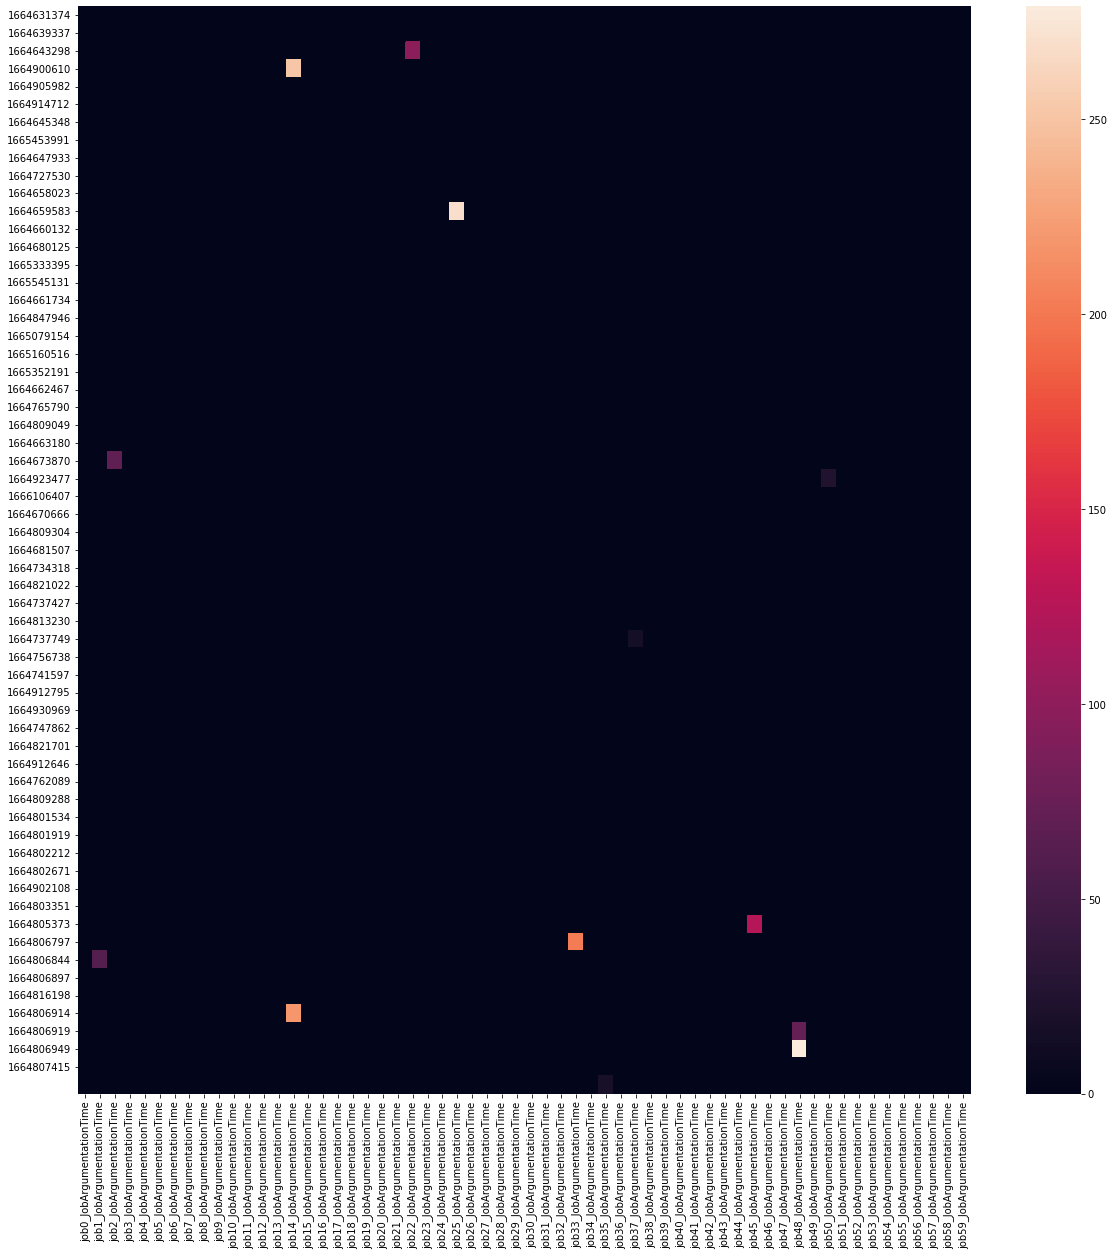

In [38]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
if Answer:
  sns.heatmap(df_Interested.loc[0:60, target_columns[1:]], yticklabels=df_Interested.SessionID[0:60], ax=ax)
else:
  sns.heatmap(df_Interested.loc[0:60, target_columns], yticklabels=df_Interested.SessionID[0:60], ax=ax)


## Some Aggregate feature visualization

#### Cleaning for visualizations

In [39]:
target_columns = df_session.columns[~df_session.columns.str.contains('job')]
df_Aggregate = df_session[target_columns].copy()

In [40]:
df_Aggregate.head()

,index,SessionID,PlayerID,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionDuration,SessionGuideCount,SessionHelpCount,SessionID.1,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserSessionCount,UserTotalSessionDuration
0,1,1664631374,EternalLava,0 days 00:12:31,"['displaced-reef', 'turtle-danger']",2,0 days 00:16:45,0,0,1664631374,2,6,"{""displaced-reef"": {""turtle-danger"": [""Eternal...","{""coral-fake-fix"": {""displaced-reef"": [""Eterna...",0 days 00:00:56,0 days 00:00:22,0 days 00:00:56,142418.5,2,284837
1,2,1664639337,EternalLava,0 days 00:08:03,[],2,0 days 00:08:58,0,1,1664639337,0,1,{},{},0 days 00:00:00,0 days 00:00:21,0 days 00:00:00,142185.0,2,284370
2,3,1664643298,EternalLava,0 days 00:15:46,[],0,0 days 00:24:41,0,9,1664643298,0,1,{},{},0 days 00:01:37,0 days 00:00:00,0 days 00:01:48,142656.5,2,285313
3,4,1664900610,EternalLava,0 days 00:19:04,[],1,0 days 00:24:15,0,4,1664900610,0,2,{},"{""coral-fake-fix"": {""kelp-save-urchin-barren"":...",0 days 00:04:11,0 days 00:00:08,0 days 00:00:50,142643.5,2,285287
4,5,1664905982,EternalLava,0 days 00:02:00,[],0,0 days 00:10:39,0,0,1664905982,0,1,{},{},0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,142235.5,2,284471


In [41]:
target_columns = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime', 'UserSessionCount', 'SessionJobsCompleted', 'SwitchJobsCount']
for col in ['ActiveTime', 'TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']:
  df_Aggregate[col] = df_Aggregate[col].dt.total_seconds()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50bcca0390>,
      dtype=object)

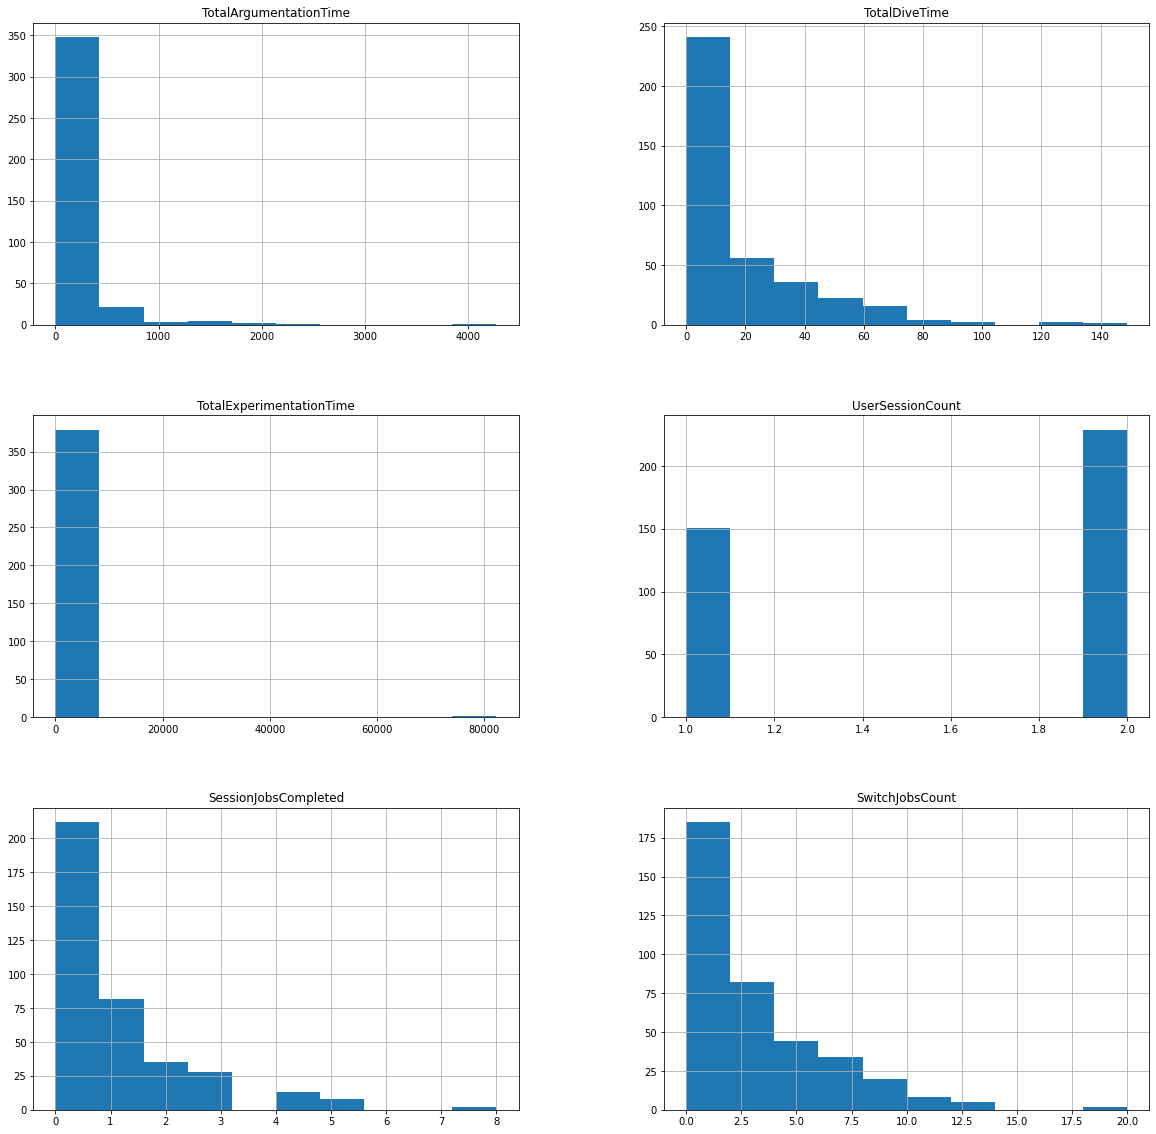

In [42]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

Here we find that there may be an outlier in TotalExperimentationTime feature. Let's remove it and impute with 0. For some other data, you can do your own cleaning and use other imputation method.

In [43]:
df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > 5000]

,index,SessionID,PlayerID,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionDuration,SessionGuideCount,SessionHelpCount,SessionID.1,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,job0_JobArgumentationTime,job1_JobArgumentationTime,job2_JobArgumentationTime,job3_JobArgumentationTime,job4_JobArgumentationTime,job5_JobArgumentationTime,job6_JobArgumentationTime,job7_JobArgumentationTime,job8_JobArgumentationTime,job9_JobArgumentationTime,job10_JobArgumentationTime,job11_JobArgumentationTime,job12_JobArgumentationTime,job13_JobArgumentationTime,job14_JobArgumentationTime,job15_JobArgumentationTime,job16_JobArgumentationTime,job17_JobArgumentationTime,job18_JobArgumentationTime,job19_JobArgumentationTime,job20_JobArgumentationTime,job21_JobArgumentationTime,job22_JobArgumentationTime,job23_JobArgumentationTime,job24_JobArgumentationTime,job25_JobArgumentationTime,job26_JobArgumentationTime,job27_JobArgumentationTime,job28_JobArgumentationTime,job29_JobArgumentationTime,job30_JobArgumentationTime,job31_JobArgumentationTime,job32_JobArgumentationTime,job33_JobArgumentationTime,job34_JobArgumentationTime,job35_JobArgumentationTime,job36_JobArgumentationTime,job37_JobArgumentationTime,job38_JobArgumentationTime,job39_JobArgumentationTime,job40_JobArgumentationTime,job41_JobArgumentationTime,job42_JobArgumentationTime,job43_JobArgumentationTime,job44_JobArgumentationTime,job45_JobArgumentationTime,job46_JobArgumentationTime,job47_JobArgumentationTime,job48_JobArgumentationTime,job49_JobArgumentationTime,job50_JobArgumentationTime,job51_JobArgumentationTime,job52_JobArgumentationTime,job53_JobArgumentationTime,job54_JobArgumentationTime,job55_JobArgumentationTime,job56_JobArgumentationTime,job57_JobArgumentationTime,job58_JobArgumentationTime,job59_JobArgumentationTime,job0_JobCompletionTime,job1_JobCompletionTime,job2_JobCompletionTime,job3_JobCompletionTime,job4_JobCompletionTime,job5_JobCompletionTime,job6_JobCompletionTime,job7_JobCompletionTime,job8_JobCompletionTime,job9_JobCompletionTime,job10_JobCompletionTime,job11_JobCompletionTime,job12_JobCompletionTime,job13_JobCompletionTime,job14_JobCompletionTime,job15_JobCompletionTime,job16_JobCompletionTime,job17_JobCompletionTime,job18_JobCompletionTime,job19_JobCompletionTime,job20_JobCompletionTime,job21_JobCompletionTime,job22_JobCompletionTime,job23_JobCompletionTime,job24_JobCompletionTime,job25_JobCompletionTime,job26_JobCompletionTime,job27_JobCompletionTime,job28_JobCompletionTime,job29_JobCompletionTime,job30_JobCompletionTime,job31_JobCompletionTime,job32_JobCompletionTime,job33_JobCompletionTime,job34_JobCompletionTime,job35_JobCompletionTime,job36_JobCompletionTime,job37_JobCompletionTime,job38_JobCompletionTime,job39_JobCompletionTime,job40_JobCompletionTime,job41_JobCompletionTime,job42_JobCompletionTime,job43_JobCompletionTime,job44_JobCompletionTime,job45_JobCompletionTime,job46_JobCompletionTime,job47_JobCompletionTime,job48_JobCompletionTime,job49_JobCompletionTime,job50_JobCompletionTime,job51_JobCompletionTime,job52_JobCompletionTime,job53_JobCompletionTime,job54_JobCompletionTime,job55_JobCompletionTime,job56_JobCompletionTime,job57_JobCompletionTime,job58_JobCompletionTime,job59_JobCompletionTime,job0_JobDiveSitesCount,job1_JobDiveSitesCount,job2_JobDiveSitesCount,job3_JobDiveSitesCount,job4_JobDiveSitesCount,job5_JobDiveSitesCount,job6_JobDiveSitesCount,job7_JobDiveSitesCount,job8_JobDiveSitesCount,job9_JobDiveSitesCount,job10_JobDiveSitesCount,job11_JobDiveSitesCount,job12_JobDiveSitesCount,job13_JobDiveSitesCount,job14_JobDiveSitesCount,job15_JobDiveSitesCount,job16_JobDiveSitesCount,job17_JobDiveSitesCount,job18_JobDiveSitesCount,job19_JobDiveSitesCount,job20_JobDiveSitesCount,job21_JobDiveSitesCount,job22_JobDiveSitesCount,job23_JobDiveSitesCount,job24_JobDiveSitesCount,job25_JobDiveSitesCount,job26_JobDiveSitesCount,job27_JobDiveSitesCount,job28_Job

In [44]:
Experimentation_columns = df_session.columns[df_session.columns.str.contains("JobExperimentation")]
temp = df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > 5000, Experimentation_columns]
temp

,job0_JobExperimentationTime,job1_JobExperimentationTime,job2_JobExperimentationTime,job3_JobExperimentationTime,job4_JobExperimentationTime,job5_JobExperimentationTime,job6_JobExperimentationTime,job7_JobExperimentationTime,job8_JobExperimentationTime,job9_JobExperimentationTime,job10_JobExperimentationTime,job11_JobExperimentationTime,job12_JobExperimentationTime,job13_JobExperimentationTime,job14_JobExperimentationTime,job15_JobExperimentationTime,job16_JobExperimentationTime,job17_JobExperimentationTime,job18_JobExperimentationTime,job19_JobExperimentationTime,job20_JobExperimentationTime,job21_JobExperimentationTime,job22_JobExperimentationTime,job23_JobExperimentationTime,job24_JobExperimentationTime,job25_JobExperimentationTime,job26_JobExperimentationTime,job27_JobExperimentationTime,job28_JobExperimentationTime,job29_JobExperimentationTime,job30_JobExperimentationTime,job31_JobExperimentationTime,job32_JobExperimentationTime,job33_JobExperimentationTime,job34_JobExperimentationTime,job35_JobExperimentationTime,job36_JobExperimentationTime,job37_JobExperimentationTime,job38_JobExperimentationTime,job39_JobExperimentationTime,job40_JobExperimentationTime,job41_JobExperimentationTime,job42_JobExperimentationTime,job43_JobExperimentationTime,job44_JobExperimentationTime,job45_JobExperimentationTime,job46_JobExperimentationTime,job47_JobExperimentationTime,job48_JobExperimentationTime,job49_JobExperimentationTime,job50_JobExperimentationTime,job51_JobExperimentationTime,job52_JobExperimentationTime,job53_JobExperimentationTime,job54_JobExperimentationTime,job55_JobExperimentationTime,job56_JobExperimentationTime,job57_JobExperimentationTime,job58_JobExperimentationTime,job59_JobExperimentationTime
169,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:01:15,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days


Notice: I used a hacky approach to remove outliers here

In [45]:
df_Aggregate.TotalExperimentationTime = df_Aggregate.TotalExperimentationTime.mask(df_Aggregate.TotalExperimentationTime>5000, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50bc87a710>,
      dtype=object)

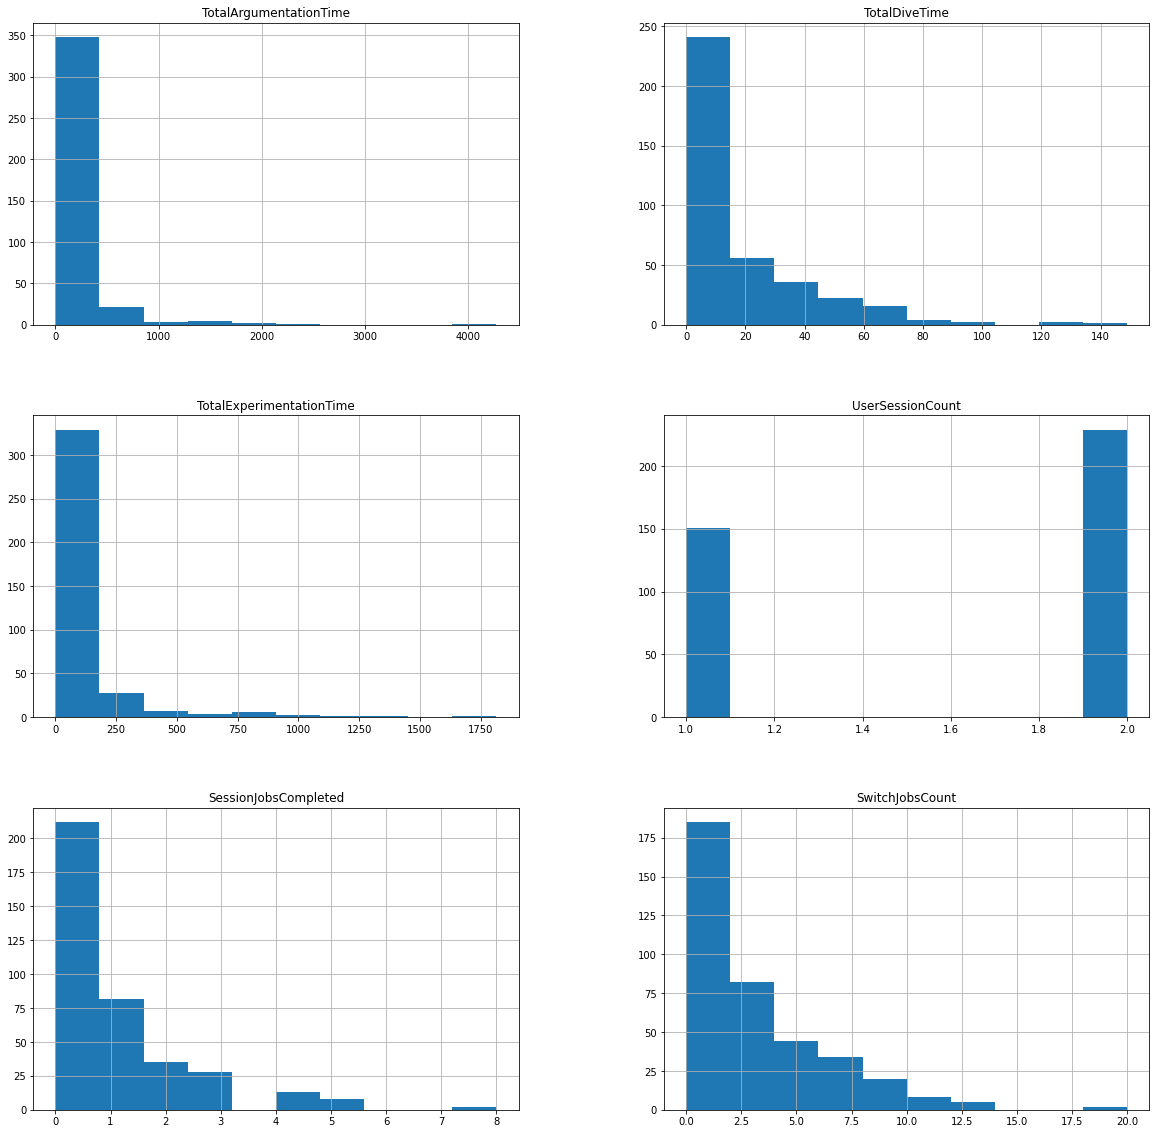

In [46]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

In [47]:
col1 = 'SessionJobsCompleted' #@param{type:"string"}
col2 = 'SwitchJobsCount'#@param{type:"string"}

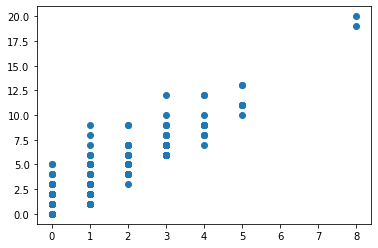

In [48]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])

In [49]:
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

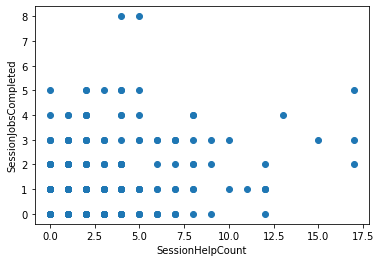

In [50]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
plt.xlabel(col1)
plt.ylabel(col2)

You may want to see more advanced relationship via plots. Here is an example

Text(0, 0.5, 'SessionJobsCompleted/ActiveTime')

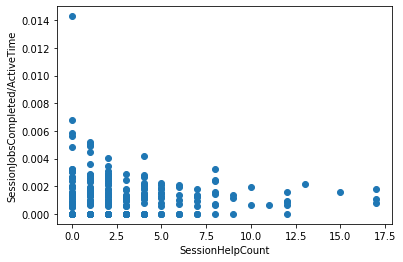

In [51]:
plt.scatter(df_Aggregate.SessionHelpCount, df_Aggregate.SessionJobsCompleted/df_Aggregate.ActiveTime)
plt.xlabel("SessionHelpCount")
plt.ylabel("SessionJobsCompleted/ActiveTime")

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [52]:
#@markdown Choose your own metric for test here
Group_column = "TotalDiveTime" #@param {type:'string'}
Dividing_value = "20" #@param {type: 'string'}
Interested_column = "TotalExperimentationTime" #@param {type: 'string'}

In [53]:
df_Aggregate['groups'] = df_Aggregate[Group_column].ge(20)

In [54]:
df_Aggregate.shape

(380, 21)

In [55]:
pairwise = pairwise_tukeyhsd(endog=df_Aggregate[Interested_column], groups=df_Aggregate.groups, alpha=0.05)
print(pairwise)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 False   True   36.683 0.1157 -9.0625 82.4285  False
----------------------------------------------------


# Classification tasks

## Splitting data

In [60]:
df_NN = df_Aggregate.copy()

In [61]:
Predictors = ['TotalArgumentationTime', 'TotalExperimentationTime',
              'SessionDiveSitesCount',
              'ActiveTime', 'SessionHelpCount']
Responses = ['SessionJobsCompleted', "TotalDiveTime"]
cut_value = [1, 20]

In [62]:
for r, v in zip(Responses, cut_value):
  df_NN['group_'+r] = (df_NN[r] > v).astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [63]:
X = df_NN[Predictors]
y = df_NN[['group_' + r for r in Responses]]
X_norm = (X - X.min())/(X.max() - X.min())
X_norm = np.asarray(X_norm).astype('float32')
y_norm = (y - y.min())/(y.max() - y.min())
x_train_full, x_test, y_train_full, y_test = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2, shuffle=True)
x_train.shape

(243, 5)

## Training models

In [64]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(y_train.shape[1], activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 300)               1800      
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 32,102
Trainable params: 32,102
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.003),
              metrics=[keras.metrics.binary_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [66]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=40)

Epoch 1/30
7/7 [==============================] - 1s 44ms/step - loss: 0.6925 - binary_accuracy: 0.7366 - val_loss: 0.6908 - val_binary_accuracy: 0.6885
Epoch 2/30
7/7 [==============================] - 0s 9ms/step - loss: 0.6912 - binary_accuracy: 0.7366 - val_loss: 0.6898 - val_binary_accuracy: 0.6885
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6899 - binary_accuracy: 0.7366 - val_loss: 0.6889 - val_binary_accuracy: 0.6885
Epoch 4/30
7/7 [==============================] - 0s 10ms/step - loss: 0.6889 - binary_accuracy: 0.7366 - val_loss: 0.6879 - val_binary_accuracy: 0.6885
Epoch 5/30
7/7 [==============================] - 0s 8ms/step - loss: 0.6876 - binary_accuracy: 0.7366 - val_loss: 0.6868 - val_binary_accuracy: 0.6885
Epoch 6/30
7/7 [==============================] - 0s 10ms/step - loss: 0.6864 - binary_accuracy: 0.7366 - val_loss: 0.6858 - val_binary_accuracy: 0.6885
Epoch 7/30
7/7 [==============================] - 0s 9ms/step - loss: 0.6852 - binary

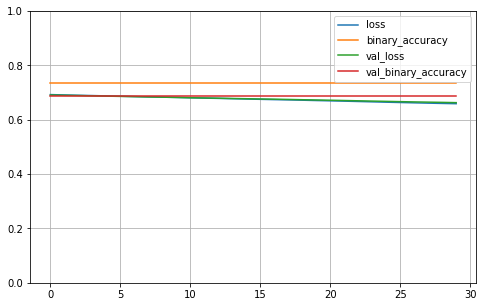

In [67]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# SOlution? REsolve

## Evaluation on the test data

In [68]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 2 samples")
predictions = model.predict(x_test[:3])
print("predictions:", predictions)
print("target_values:", y_test[:3])

Evaluate on test data
3/3 [==============================] - 0s 4ms/step - loss: 0.6508 - binary_accuracy: 0.7697
test loss, test acc: [0.6508499979972839, 0.7697368264198303]
Generate predictions for 2 samples
1/1 [==============================] - 0s 90ms/step
predictions: [[0.4546385  0.47081777]
 [0.45546988 0.467019  ]
 [0.45321342 0.46375987]]
target_values:      group_SessionJobsCompleted  group_TotalDiveTime
361                         0.0                  0.0
322                         0.0                  0.0
124                         1.0                  0.0


In [69]:
predictions = model.predict(x_test)

3/3 [==============================] - 0s 6ms/step


Take SessionJobsCompleted as an example

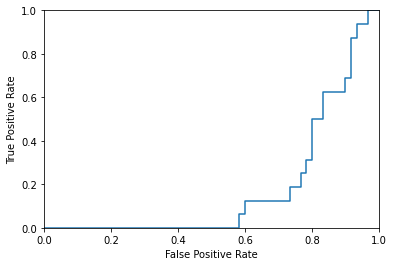

In [70]:
fpr , tpr , thresholds = roc_curve (y_true=y_test.iloc[:,0], y_score=predictions[:,0])
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show() 

In [71]:
print("auc score: ", roc_auc_score(y_test.iloc[:,0], predictions[:,0]))

auc score:  0.18229166666666669
